In [1]:
from utils.hw4_utils import *
from utils.hw4_model import CNF, HCNF
from torch.utils.data import DataLoader

# Question 1: 2D Data


Dataset 1


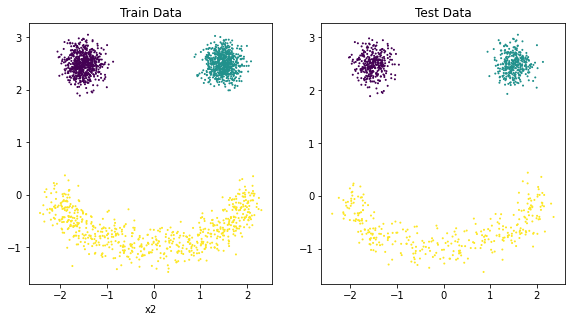

Dataset 2


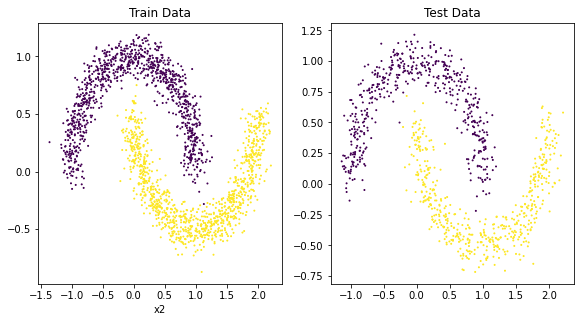

In [2]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Continious Normalazing Flow

Implement continious normalazing flow from [here](https://arxiv.org/pdf/1806.07366.pdf) (botom of page 4). We will be using following transformation parametrization of $\frac{dz(t)}{dt}$:

$\frac{dz(t)}{dt} = u \tanh(\omega^t z(t) + b) \Rightarrow \frac{\partial \log p(z(t))}{\partial z} = - u^t \frac{\partial h}{\partial z}$


Here $\omega, u$ have same dim as $z$ and $b$ is a scalar.

Parametrize $u, \omega, b$ with neural network with single input t. You may find it useful to icrease the 'width' of tansformation by performing m transformation and then averaging them.

## You will provide these deliverables

* Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
* Report the final test set performance of your final model
* Show a heatmap of the densities learned by your model
* Show what the training set looks like when mapped to the latent space.

## Solution

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.



In [3]:
def q1(train_data, test_data, dset_id, epochs=100, batch_size=64, lr=1e-3, l2=0, device="cuda"):
    """
    train_data: An (n_train, 2) numpy array of floats in R^2
    test_data: An (n_test, 2) numpy array of floats in R^2
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
                used to set different hyperparameters for different datasets, or
                for plotting a different region of densities

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (?,) of probabilities with values in [0, +infinity). 
        Refer to the commented hint.
    - a numpy array of size (n_train, 2) of floats in [0,1]^2. This represents 
        mapping the train set data points through our flow to the latent space. 
    """
    
    trainloader = DataLoader(train_data.astype(np.float32), batch_size=batch_size, shuffle=True, pin_memory=True)
    testloader = DataLoader(test_data.astype(np.float32), batch_size=batch_size, pin_memory=True)
    
    model = CNF(2, 32, 5).to(device)
    model, losses = model.fit(trainloader, testloader, epochs, lr, l2)
    
    # heatmap
    dx, dy = 0.025, 0.025
    
    if dset_id == 1:  # face
        x_lim = (-4, 4)
        y_lim = (-4, 4)
    elif dset_id == 2:  # two moons
        x_lim = (-1.5, 2.5)
        y_lim = (-1, 1.5)
    
    y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                    slice(x_lim[0], x_lim[1] + dx, dx)]
    mesh_xs = torch.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2))
    
    densities = model.densities(DataLoader(torch.FloatTensor(mesh_xs), batch_size=4 * 2048))
    latents = model.latent(DataLoader(train_data.astype(np.float32), batch_size=4 * 2048))

    # latents
    return losses["train"], losses["test"], densities, latents


### Results

Once you've implemented `q1`, execute the cells below to visualize and save your results



Fitting...: 100%|██████████| 100/100 [10:12<00:00,  6.13s/it]


Final Test Loss: 1.5073


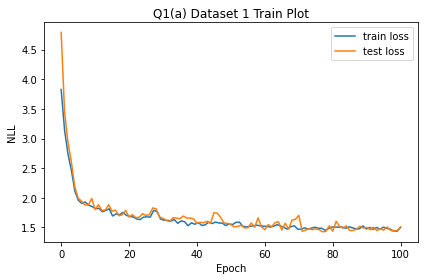

/home/breengles/Dropbox/hse/dul_2021/utils/hw4_utils.py:109: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x, y, densities.reshape([y.shape[0], y.shape[1]]))
/home/breengles/Dropbox/hse/dul_2021/utils/hw4_utils.py:110: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x, y, densities.reshape([y.shape[0], y.shape[1]]))


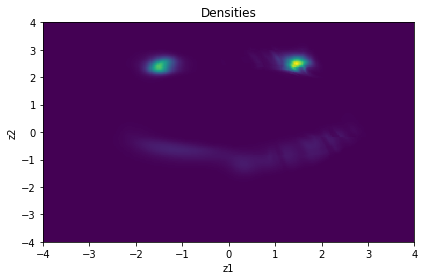

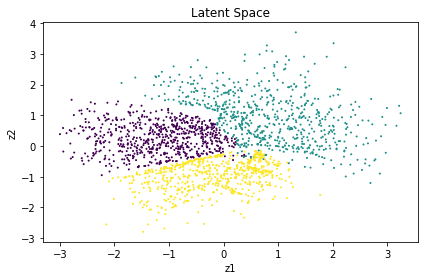

In [4]:
q1_save_results(1, 'a', q1)

Fitting...: 100%|██████████| 100/100 [07:13<00:00,  4.33s/it]


Final Test Loss: 1.3112


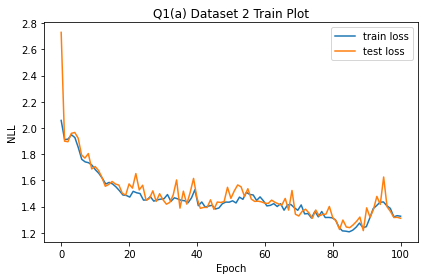

/home/breengles/Dropbox/hse/dul_2021/utils/hw4_utils.py:109: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x, y, densities.reshape([y.shape[0], y.shape[1]]))
/home/breengles/Dropbox/hse/dul_2021/utils/hw4_utils.py:110: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x, y, densities.reshape([y.shape[0], y.shape[1]]))


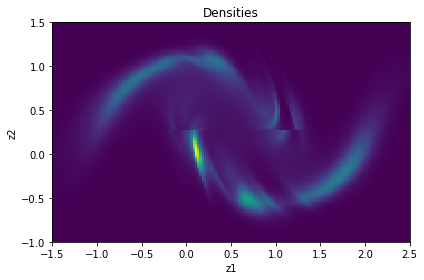

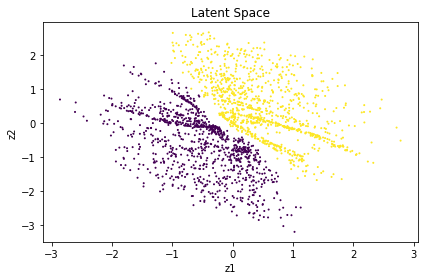

In [5]:
q1_save_results(2, 'a', q1)

# Question 2: Hutchinson's trace estimator

Implement CNF with Hutchinson trace estimator.

## You will provide these deliverables

* Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
* Report the final test set performance of your final model


## Solution

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [6]:
def q2(train_data, test_data, epochs=20, batch_size=128, lr=1e-3, l2=0, device="cuda"):
    """
    train_data: An (n_train, 10) numpy array of floats in R^10
    test_data: An (n_test, 10) numpy array of floats in R^10
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
                used to set different hyperparameters for different datasets, or
                for plotting a different region of densities

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    """

    trainloader = DataLoader(train_data.astype(np.float32), batch_size=batch_size, shuffle=True, pin_memory=True)
    testloader = DataLoader(test_data.astype(np.float32), batch_size=batch_size, pin_memory=True)
    
    model = HCNF(10, 32, 5).to(device)
    model, losses = model.fit(trainloader, testloader, epochs, lr, l2)
    
    return losses["train"], losses["test"]

### Results

Once you've implemented `q2`, execute the cells below to visualize and save your results



Fitting...: 100%|██████████| 20/20 [06:20<00:00, 19.00s/it]

Final Test Loss: 12.9419


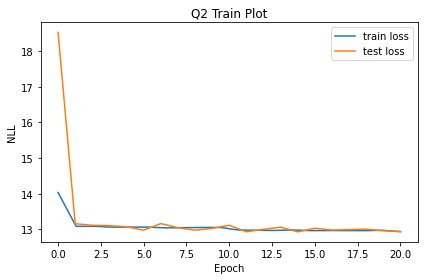

In [7]:
q2_save_results(q2)

# Bonus 3: CNF

Implement CNF with Hutchinson trace estimator and bottleneck trick

## You will provide these deliverables

* Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
* Report the final test set performance of your final model


## Solution

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [8]:
def b3(train_data, test_data):
  """
  train_data: An (n_train, 10) numpy array of floats in R^10
  test_data: An (n_test, 10) numpy array of floats in R^10
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets, or
             for plotting a different region of densities

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  """
  
  """ YOUR CODE HERE """


### Results

Once you've implemented `b3`, execute the cells below to visualize and save your results



In [9]:
q2_save_results(b3)

TypeError: cannot unpack non-iterable NoneType object